# Machine Learning Methods for TangTV Point Prediction

Methods are used for raw TV videos, inverted TV videos, and synthetic videos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
import h5py
import pickle
from tqdm.notebook import tqdm

from utils.get_file import GetTV

## TV Location Detection

### Linear Regression

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [10]:
file_path = Path('outputs/hdf5')
file_name = 'tv_inv_outer.h5'

# with h5py.File(file_path / file_name, 'r') as f:
#     vid = f['vid'][:]
#     inverted = f['inverted'][:]
#     points = f['points'][:]
#     vid_only = f['vid_only'][:]

# tv = GetTV()
# files = tv.list_files()
# elevation = tv.load(files[0], 'elevation')[0]
# radii = tv.load(files[0], 'radii')[0]
# vid_shape = tv.load(files[0], 'vid')[0].shape

<KeysViewHDF5 ['inverted_test', 'inverted_train', 'points_test', 'points_train', 'vid_test', 'vid_train']>

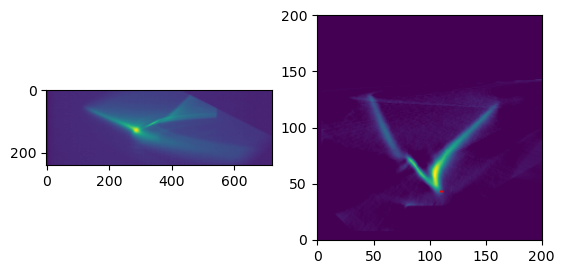

In [12]:
idx = 100
plt.subplot(1,2,1)
plt.imshow(vid_train[idx])
plt.subplot(1,2,2)
plt.imshow(inverted_train[idx],origin='lower')
plt.scatter(points_train[idx][:,0], points_train[idx][:,1], c='r', s=1)
plt.show()

In [ ]:
vid_2 = vid.reshape(len(vid), -1)
points_2 = points.reshape(len(points), -1)
X_train, X_test, y_train, y_test, _, inv_test = train_test_split(vid_2, points_2, inverted, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, inv_test.shape)

In [ ]:
regr = LinearRegression() # try ridge regression
regr.fit(X_train, y_train)

In [ ]:
r_sq = regr.score(X_test, y_test)
r_predict = regr.predict(X_test)
real_predict = np.array([radii[np.round(r_predict[:,0]).astype(int)],elevation[np.round(r_predict[:,1]).astype(int)]]).T
real_y = np.array([radii[np.round(y_test[:,0]).astype(int)],elevation[np.round(y_test[:,1]).astype(int)]]).T
print(r_sq)
print(f"RMS (cm) : {np.sqrt(mean_squared_error(real_predict, real_y)*100)}")

In [ ]:
model_file_path = Path('outputs/models')
regr_dump = LinearRegression()
regr_dump.fit(vid_2, points_2)
model_filename = model_file_path / Path('lr_' + file_name).with_suffix('.pkl')
pickle.dump(regr_dump, open(model_filename, 'wb'))

In [10]:
### Load model
model_file_path = Path('outputs/models')
model_filename = model_file_path / Path('lr_' + file_name).with_suffix('.pkl')
model = pickle.load(open(model_filename, 'rb'))
coef = model.coef_
intercept = model.intercept_
with open(model_file_path / 'lr_coef.txt', 'w') as f:
    for i in range(coef.shape[1]):
        f.write(str(coef[0][i]) + '\n')

with open(model_file_path / 'lr_intercept.txt', 'w') as f:
    for i in range(intercept.shape[0]):
        f.write(str(intercept[i]) + '\n')

c:\Users\twoga\Documents\GitHub\PlasmaControlGroup\plasma-tv\myenv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
X_test_reshape = X_test.reshape(len(X_test), vid_shape[0], vid_shape[1])

In [ ]:
r_predict_full = regr.predict(vid_2)

In [ ]:
fig, (ax, bx) = plt.subplots(2,1)

# Create scatter plots
inv_plot = ax.imshow(inverted[0], origin='lower')
scat_pred = ax.scatter([], [], c='lime', s = 5, label='predicted')
scat_actual = ax.scatter([], [], c='red', s = 5, label='actual')
vid_plot = bx.imshow(vid[0])
# ax.set_xlim([1,2])
# ax.set_ylim([-1.4,-.4])
ax.legend()
ax.set_title("Inverted View")
bx.set_title("rt-TangTV View")
ax.set_xticks([])
ax.set_yticks([])
bx.set_xticks([])
bx.set_yticks([])
fig.suptitle(f"{file_name} regression, score = {r_sq:.4f}")
plt.tight_layout()

def update(num):
    x, y = r_predict_full[num]
    a, b = points_2[num]
    inv_plot.set_data(inverted[num])
    scat_pred.set_offsets((x, y))
    scat_actual.set_offsets((a, b))
    vid_plot.set_data(vid[num])
    return inv_plot, scat_pred, scat_actual, vid_plot

FFwriter = animation.FFMpegWriter(fps=60)
ani = animation.FuncAnimation(fig, update, frames=tqdm(range(len(r_predict_full))), interval=20, blit=True)
ani.save(Path(f'./tmp/{file_name}_regress_full.gif'))
plt.close()

In [ ]:
fig, (ax, bx) = plt.subplots(2,1)

# Create scatter plots
inv_plot = ax.imshow(inv_test[0], origin='lower')
scat_pred = ax.scatter([], [], c='lime', label='predicted')
scat_actual = ax.scatter([], [], c='red', label='actual')
vid_plot = bx.imshow(X_test_reshape[0])
# ax.set_xlim([1,2])
# ax.set_ylim([-1.4,-.4])
ax.legend()
ax.set_title("Emission Front Locations")
bx.set_title("Inversion Image")
ax.set_xticks([])
ax.set_yticks([])
bx.set_xticks([])
bx.set_yticks([])
fig.suptitle(f"{file_name} regression, score = {r_sq:.4f}")
plt.tight_layout()

def update(num):
    x, y = r_predict[num]
    a, b = y_test[num]
    inv_plot.set_data(inv_test[num])
    scat_pred.set_offsets((x, y))
    scat_actual.set_offsets((a, b))
    vid_plot.set_data(X_test_reshape[num])
    return inv_plot, scat_pred, scat_actual, vid_plot

FFwriter = animation.FFMpegWriter(fps=60)
ani = animation.FuncAnimation(fig, update, frames=tqdm(range(len(r_predict))), interval=20, blit=True)
ani.save(Path(f'./tmp/{file_name}_regress_full.mp4'), writer=FFwriter)
plt.close()

### Linear Regression for Shot by Shot

In [44]:
file_path = Path('../out/hdf5')
file_name = 'tv_inv_outer.h5'

with h5py.File(file_path / file_name, 'r') as f:
    vid_train = f['vid_train'][:]
    inverted_train = f['inverted_train'][:]
    points_train = f['points_train'][:]
    vid_test = f['vid_test'][:]
    inverted_test = f['inverted_test'][:]
    points_test = f['points_test'][:]

tv = GetTV('../resources')
files = tv.list_files()
elevation = tv.load(files[0], 'elevation')[0]
radii = tv.load(files[0], 'radii')[0]
vid_shape = tv.load(files[0], 'vid')[0].shape

In [73]:
print(vid_train.shape)

(480, 240, 720)


In [74]:
720 / 240

3.0

In [87]:
# downsampling functions
downsample2d = lambda x, factor : x[:, ::factor, ::3*factor]
flatten = lambda x : x.reshape(len(x), -1)

def regr_scoring(X_train, X_test, y_train, y_test):
    regr = LinearRegression()
    regr.fit(X_train, y_train)
    r_sq = regr.score(X_test, y_test)
    r_predict = regr.predict(X_test)
    try:
        real_predict = np.array([radii[np.round(r_predict[:,0]).astype(int)],elevation[np.round(r_predict[:,1]).astype(int)]]).T
    except:
        real_predict = np.ones_like(r_predict) * 1e3
    real_y = np.array([radii[np.round(y_test[:,0]).astype(int)],elevation[np.round(y_test[:,1]).astype(int)]]).T
    rms = np.sqrt(mean_squared_error(real_predict, real_y)*100)
    return r_sq, rms

In [88]:
downsamples = range(1,30)
numpixel_array = []
r_sq_array = []
rms_array = []

for n in downsamples:
    
    vid_train_down = downsample2d(vid_train, n)
    vid_test_down = downsample2d(vid_test, n)
    
    vid_train_down_reshape = flatten(vid_train_down)
    vid_test_down_reshape = flatten(vid_test_down)
    points_train_reshape = flatten(points_train)
    points_test_reshape = flatten(points_test)
    
    numpixel = vid_train_down_reshape.shape[1]
    
    r_sq, rms = regr_scoring(vid_train_down_reshape, vid_test_down_reshape, points_train_reshape, points_test_reshape)
    
    numpixel_array.append(numpixel)
    r_sq_array.append(r_sq)
    rms_array.append(rms)

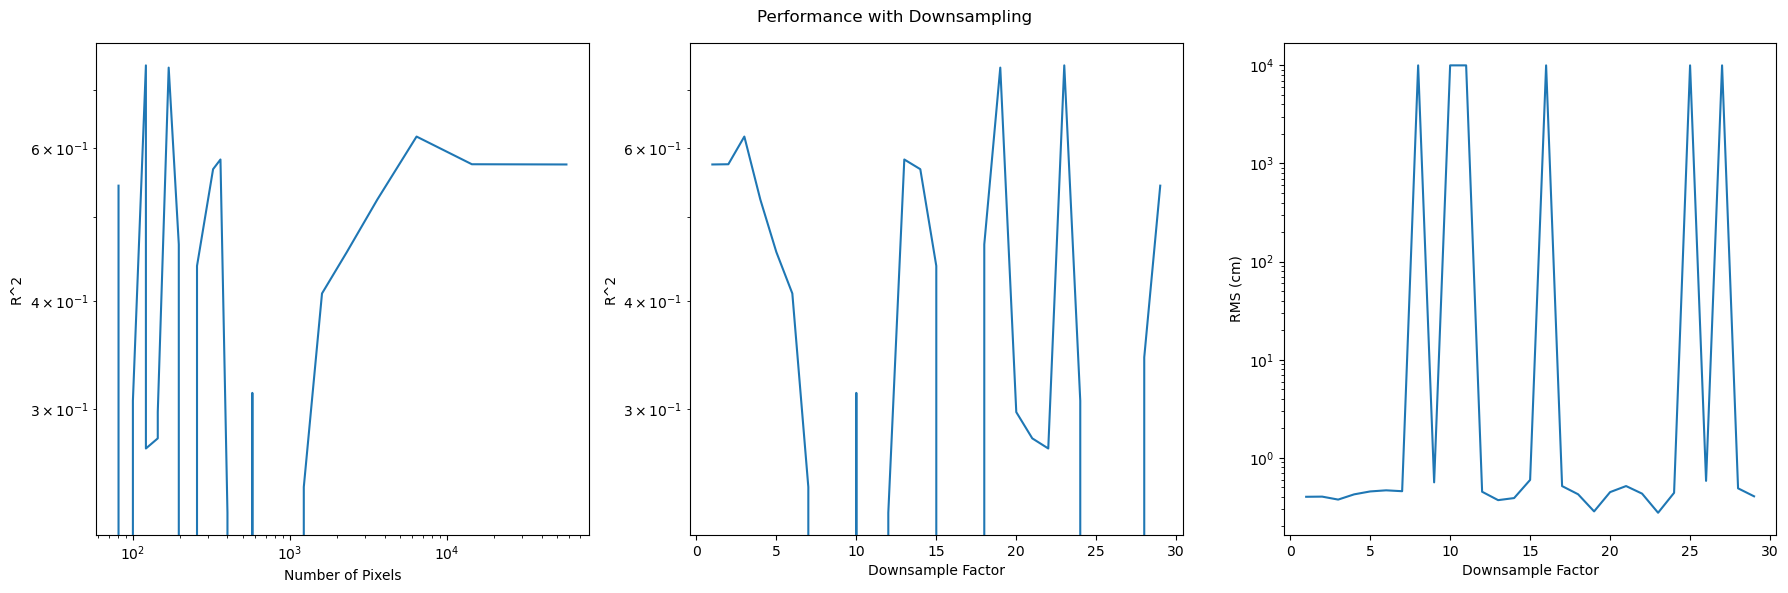

In [97]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.loglog(numpixel_array, r_sq_array)
plt.xlabel("Number of Pixels")
plt.ylabel("R^2")
plt.subplot(1,3,2)
plt.semilogy(downsamples, r_sq_array)
plt.xlabel("Downsample Factor")
plt.ylabel("R^2")
plt.subplot(1,3,3)
plt.semilogy(downsamples, rms_array)
plt.xlabel("Downsample Factor")
plt.ylabel("RMS (cm)")
plt.suptitle('Performance with Downsampling')
plt.tight_layout()
plt.show()

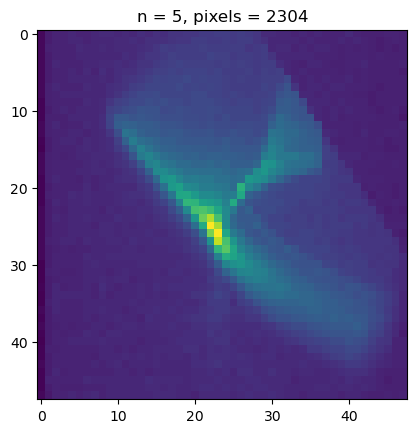

In [90]:
down_n = 5
sample_im = downsample2d(vid_train, down_n)[0]
sample_pixel_num = sample_im.shape[0] * sample_im.shape[1]
plt.imshow(downsample2d(vid_train, down_n)[0])
plt.title(f"n = {down_n}, pixels = {sample_pixel_num}")
plt.show()

In [18]:
r_sq = regr.score(vid_test_reshape, points_test_reshape)
r_predict = regr.predict(vid_test_reshape)
real_predict = np.array([radii[np.round(r_predict[:,0]).astype(int)],elevation[np.round(r_predict[:,1]).astype(int)]]).T
real_y = np.array([radii[np.round(points_test_reshape[:,0]).astype(int)],elevation[np.round(points_test_reshape[:,1]).astype(int)]]).T
rms = np.sqrt(mean_squared_error(real_predict, real_y)*100)
print(r_sq)
print(f"RMS (cm) : {rms}")

0.5745020689331939
RMS (cm) : 0.4023272791055848


In [ ]:
fig, (ax, bx) = plt.subplots(2,1)

# Create scatter plots
inv_plot = ax.imshow(inverted_test[0], origin='lower')
scat_pred = ax.scatter([], [], c='lime', s = 5, label='predicted')
scat_actual = ax.scatter([], [], c='red', s = 5, label='actual')
vid_plot = bx.imshow(vid_test[0])
# ax.set_xlim([1,2])
# ax.set_ylim([-1.4,-.4])
ax.legend()
ax.set_title("Inverted View")
bx.set_title("rt-TangTV View")
ax.set_xticks([])
ax.set_yticks([])
bx.set_xticks([])
bx.set_yticks([])
fig.suptitle(f"{file_name} regression, RMS (cm) = {rms:.4f}")
plt.tight_layout()

def update(num):
    x, y = r_predict[num]
    a, b = points_test_reshape[num]
    inv_plot.set_data(inverted_test[num])
    scat_pred.set_offsets((x, y))
    scat_actual.set_offsets((a, b))
    vid_plot.set_data(vid_test[num])
    return inv_plot, scat_pred, scat_actual, vid_plot

FFwriter = animation.FFMpegWriter(fps=60)
ani = animation.FuncAnimation(fig, update, frames=tqdm(range(len(r_predict))), interval=20, blit=True)
ani.save(Path(f'./tmp/{file_name}_regress_full.gif'))
plt.close()

### Neural Network

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary

In [ ]:
file_path = Path('.\hdf5')
file_names = ['tv_raw.hdf5', 'tv_crop.hdf5', 'tv_process.hdf5']
file_name = file_path / file_names[0]

In [ ]:
with h5py.File(file_name, 'r') as f:
    target = f['tv_images'][:]
    label = f['points'][:]

target_norm = 127.5
target_std = 255
label_norm = np.mean(label,axis=0)
label_std = np.std(label,axis=0)
del target
del label

In [ ]:
print(f"target_mean: {target_norm:.4f}")
print(f"target_std: {target_std:.4f}")
print(f"label_mean: {label_norm}")
print(f"label_std: {label_std}")

In [ ]:
class TVDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.file = h5py.File(file_path, 'r')
        self.target = self.file['tv_images'][:][:, np.newaxis, ...] / 255
        self.label = self.file['points'][:]
        self.transform = transform
        self.file.close()
        if transform:
            self.target = transform(torch.from_numpy(self.target).float())
            self.label = torch.from_numpy(self.label).float()

    def __len__(self):
        return self.target.shape[0]

    def __getitem__(self, idx):
        target = self.target[idx]
        label = self.label[idx]
        return target, label

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1)
        self.pool = nn.MaxPool2d(8, 8)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
        self.fc1 = nn.Linear(672 , 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(256*256, 256)
        self.fc2 = nn.Linear(256, 4)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_model(model, dataloader, optimizer, criterion, n_epochs, device):
    model.train()
    loss_norm = len(dataloader.dataset)
    for epoch in range(n_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        print(f'{epoch + 1} loss: {running_loss / loss_norm:.3}')

    print('Finished Training')
    return model

In [ ]:
# transform = CustomTransform(target_norm, label_norm, target_std, label_std)
transform = T.Resize(size = (256,256), antialias=True)
test_dataset = TVDataset(file_name, transform = transform)

In [ ]:
print(len(test_dataset))
train_num = int(len(test_dataset)*0.8)

In [ ]:
batch_size = 256
train, test = random_split(test_dataset, [train_num, len(test_dataset) - train_num])
dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
print(f"target datatype = {test_dataset[0][0].dtype}, label datatype = {test_dataset[0][1].dtype}")
print(f"dataset length = {len(test_dataset)}")
print(f'label = {test_dataset[0][1]}')
im_ratio = test_dataset[0][0][0].shape[1]/test_dataset[0][0][0].shape[0]
plt.imshow(test_dataset[0][0][0], cmap = 'plasma')
plt.colorbar(orientation="horizontal",fraction=0.047*im_ratio)
plt.title("target")
plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
# summary(model, input_size = (1, 250, 250))

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 35

model = train_model(model, dataloader, optimizer, criterion, n_epochs, device)

### Visualize Evaluation

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
# Assuming you have loaded the new dataset into a variable named `new_dataset`
# and created a dataloader for it named `new_dataloader`
new_dataloader = DataLoader(test, batch_size=batch_size,
                        shuffle=False, num_workers=0)
n_samples = len(new_dataloader.dataset)
output_size = len(new_dataloader.dataset[0][1])
predicted = np.zeros((n_samples, output_size))
actual = np.zeros((n_samples, output_size))
model.eval()

# Iterate over the dataloader and predict the output for each input
with torch.no_grad():
    start_index = 0
    for inputs, actual_outputs in new_dataloader:
        inputs = inputs.to(device)
        predicted_outputs = model(inputs)
        end_index = start_index + predicted_outputs.shape[0]
        predicted[start_index:end_index] = predicted_outputs.cpu().numpy()
        actual[start_index:end_index] = actual_outputs.numpy()
        start_index = end_index

In [ ]:
renorm_actual = new_dataloader.dataset[:][1].numpy()
renorm_predicted = predicted

print(renorm_actual)
print(renorm_predicted)

In [ ]:
print(f"RMS (cm) : {np.sqrt(mean_squared_error(renorm_actual, renorm_predicted))*100}")

In [ ]:
fig, ax = plt.subplots()

# Create scatter plots
scat_pred = ax.scatter([], [], c='lime', label='predicted')
scat_actual = ax.scatter([], [], c='red', label='actual')
ax.set_xlim([1,2])
ax.set_ylim([-1.4,-.4])
ax.legend()
ax.set_title(f"{file_name.stem} : {scores}")

def update(num):
    x1, y1, x2, y2 = renorm_predicted[num]
    a1, b1, a2, b2 = renorm_actual[num]
    scat_pred.set_offsets(np.c_[[x1, x2], [y1, y2]])
    scat_actual.set_offsets(np.c_[[a1, a2], [b1, b2]])
    return scat_pred, scat_actual

FFwriter = animation.FFMpegWriter(fps=60)
ani = animation.FuncAnimation(fig, update, frames=tqdm(range(len(predicted))), interval=20, blit=True)
ani.save(Path(f'./tmp/{file_name.stem}.mp4'), writer=FFwriter)
plt.close()

## Inversion Location Detection for Semi-Supervised Learning

### Linear Regression

In [ ]:
import cv2

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
file_path = Path('.\outputs\hdf5')
model_file_path = Path('.\models')
file_names = ['tv_raw.hdf5', 's_outs_v3_limited.h5', 'inversion_manual.hdf5']
file_name = file_path / file_names[2]

tv = GetTV()
files = tv.list_files()
elevation = tv.load(files[0], 'elevation')[0]
radii = tv.load(files[0], 'radii')[0]

In [ ]:
# with h5py.File(file_name, 'r') as f:
#     l_r, l_z, r_r, r_z = f['rz'][:].T
#     l_a, r_a = f['intensity'][:].T
    
# manual inversion points
with h5py.File(file_name, 'r') as f:
    inverted = f['inverted'][:]
    points = f['points'][:]

In [ ]:
print(np.max(points))
print(np.min(points))

In [ ]:
print(inverted.shape)
inv_dim = inverted.shape[1] * inverted.shape[2]

In [ ]:
idx = 180
plt.imshow(inverted[idx],origin='lower')
plt.scatter(points[idx][0], points[idx][1], c='red')
plt.show()
image = inverted.copy()

In [ ]:
# image = np.array([np.resize(image[i], (256, 256)) for i in range(len(image))])
# image = np.array([cv2.resize(image[i], (256, 256)) for i in range(len(image))])

In [ ]:
X_train, X_test_raw, y_train, y_test = train_test_split(image, points, test_size=0.2)
X_train = X_train.reshape((len(X_train), -1))
X_test = X_test_raw.reshape((len(X_test_raw), -1))

In [ ]:
print(X_test.shape)
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
regr = LinearRegression() # try ridge regression
regr.fit(X_train, y_train)
r_sq = regr.score(X_test, y_test)
r_predict = regr.predict(X_test)
print(r_sq)

In [ ]:
print(f"RMS (cm) : {np.sqrt(mean_squared_error(y_test, r_predict))*100}")

In [ ]:
image2 = image.reshape((len(image), -1))
print(image2.shape)

In [ ]:
regr_dump = LinearRegression()
regr_dump.fit(image2, points)

In [ ]:
a, b = y_test[1]
print(radii[int(a)], elevation[int(b)])

In [ ]:
model_filename = model_file_path / Path('lr_' + file_name.stem).with_suffix('.pkl')
pickle.dump(regr_dump, open(model_filename, 'wb'))

In [ ]:
model_filename = model_file_path / Path('lr_' + file_name.stem).with_suffix('.pkl')
loaded_model = pickle.load(open(model_filename, 'rb'))

In [ ]:
fig, (ax, bx) = plt.subplots(2,1)

# Create scatter plots
scat_pred = ax.scatter([], [], c='lime', label='predicted')
scat_actual = ax.scatter([], [], c='red', label='actual')
tv_image_plot = bx.imshow(X_test_raw[0])
scat_image = bx.scatter([], [], c='red', s=1)
ax.set_xlim([1,2])
ax.set_ylim([-1.4,-.4])
ax.legend()
ax.set_title("Emission Front Locations")
bx.set_title("Inversion Image")
fig.suptitle(f"{file_name.stem} regression, score = {r_sq:.4f}")
plt.tight_layout()

# def update(num):
#     x1, y1, x2, y2 = r_predict[num]
#     a1, b1, a2, b2 = y_test[num]
#     scat_pred.set_offsets(np.c_[[x1, x2], [y1, y2]])
#     scat_actual.set_offsets(np.c_[[a1, a2], [b1, b2]])
#     tv_image_plot.set_data(image[num])
#     return scat_pred, scat_actual, tv_image_plot

def update(num):
    x1, y1 = r_predict[num]
    a1, b1 = y_test[num]
    scat_pred.set_offsets([radii[int(x1)], elevation[int(y1)]])
    scat_actual.set_offsets([radii[int(a1)], elevation[int(b1)]])
    tv_image_plot.set_data(X_test_raw[num])
    scat_image.set_offsets([a1, b1])
    return scat_pred, scat_actual, tv_image_plot

FFwriter = animation.FFMpegWriter(fps=60)
ani = animation.FuncAnimation(fig, update, frames=tqdm(range(len(r_predict))), interval=10, blit=True)
ani.save(Path(f'./tmp/stuff/{file_name.stem}_regress.gif'), writer='Pillow')
plt.close()

### Test on Synthetic Data

In [ ]:
def _make_samples():
    
    # Make R0s, Z0s, A0s, M0s
    nsp = 5

    R0s = np.zeros((nsp, 2))
    Z0s = np.zeros((nsp, 2))
    # Make R0s, Z0s, A0s, M0s
    R0s_S = np.repeat(np.repeat(np.repeat(np.linspace(1.4, 1.7, nsp), nsp), nsp), nsp)
    Z0s_S = np.tile(np.repeat(np.repeat(np.linspace(-1.3, -1.2, nsp), nsp), nsp), nsp)

    R0s_X = np.repeat(np.tile(np.tile(np.linspace(1.3, 1.6, nsp), nsp), nsp), nsp)
    Z0s_X = np.tile(np.tile(np.tile(np.linspace(-1.2, -0.9, nsp), nsp), nsp), nsp)

    R0s = np.array([R0s_S, R0s_X]).T
    Z0s = np.array([Z0s_S, Z0s_X]).T
    
    return R0s, Z0s

In [ ]:
import cv2

In [ ]:
file_name = 'outputs/hdf5/s_outs_v3_limited.h5'
with h5py.File(file_name, 'r') as f:
    print(list(f.keys()))
    synthetic_images = f['image'][:]

file_name_2 = 'outputs/hdf5/x_outer_radiation.hdf5'
with h5py.File(file_name_2, 'r') as f:
    print(list(f.keys()))
    points = f['points'][:]
    tv_images = f['tv_images'][:]

note: s_outs_v3_limited is x point and outer radiation point. points is l_r, l_z, r_r, r_z

In [ ]:
# R0s, Z0s = _make_samples()

In [ ]:
print(synthetic_images.shape)
print(tv_images.shape)

In [ ]:
idx = 1000
# TV Images
plt.subplot(2, 2, 1)
plt.imshow(cv2.flip(tv_images[idx],0), origin='lower')
plt.colorbar(orientation='horizontal', ax=plt.gca())
plt.title('TV Images')

# Synthetic Images
plt.subplot(2, 2, 2)
plt.imshow(synthetic_images[idx], origin='lower')
plt.colorbar(orientation='horizontal', ax=plt.gca())
plt.title('Synthetic Images')

plt.tight_layout()
plt.show()

In [ ]:
image2 = np.array([np.resize(synthetic_images[i], (256, 256)) for i in range(len(synthetic_images))])
image2 = image2.reshape((len(image2), -1))

In [ ]:
image3 = np.array([np.resize(cv2.flip(tv_images[i],0), (256, 256)) for i in range(len(tv_images))])
image3 = image3.reshape((len(image3), -1))

In [ ]:
X_train, _, X_train_discard, X_test, y_train, y_test = train_test_split(image2, image3, points, test_size=0.2)

y_train = y_train[:,[2,3]] / 201
y_test = y_test[:,[2,3]] / 201
# X_train = X_train / X_train.max() * 0.92
X_test = X_test / 255

In [ ]:
regr = Ridge() # try ridge regression
regr.fit(X_train, y_train)

In [ ]:
print(y_test.max())

In [ ]:
r_sq = regr.score(X_test, y_test)
r_predict = regr.predict(X_test)
print(f"RMS (cm) : {np.sqrt(mean_squared_error(y_test, r_predict))*100}")
print(f"R2_Score : {r_sq}")

In [ ]:
print(y_test[60])
print(r_predict[60])

In [ ]:
plt.scatter(y_test[0,0], y_test[0,1], c='lime', label='actual')
plt.scatter(r_predict[0,0], r_predict[0,1], c='red', label='predicted')
plt.show()

10 ms
1. RZA database
2. Error Linear, Normal Regression, and Ridge Regression
3. Test thing on synthetic

Delta Z * gain = target voltage (with constant scaling factor tune during experiment). D2, N2 gas puff

V1, V2, V3, V4 (how far away from wall)